## Reading in data available from the Sol Genomics Network (SGN) database
The purpose of this notebook is to read in and do a preliminary survey of the data related to text descriptions obtained from the Sol Genomics Network. The data was provided in the form of the input file by request, rather than obtained through an already available file from the database. The data needs to be organized and restructured into a standard format that will allow it to be easily combined with datasets from other resources.

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
import os
import warnings
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

sys.path.append("../../oats")
from oats.utils.utils import to_abbreviation
from oats.nlp.preprocess import concatenate_with_bar_delim
from oats.nlp.preprocess import other_delim_to_bar_delim
from oats.nlp.preprocess import remove_punctuation
from oats.nlp.preprocess import remove_enclosing_brackets

OUTPUT_DIR = "../data/reshaped_files"
mpl.rcParams["figure.dpi"] = 200
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Part 1: Phenotypic Text Data
Note that fillna is being used here to replace missing values with an empty string. This is done so that the missing string will be quantified when checking for the number of occurences of unique values from different columns, see the analysis below. However this is not necessary as a preprocessing step because when the data is read in and appended to a dataset object later, any missing values or empty strings will be handled at that step.

There are several columns that contain information about gene names and accessions. We need to know what type of information is in each in order to know which should be retained in the dataset we are preparing. We are interested in both gene names that should map to a specific accession (like cyp716A12 or Medtr3g021350) as well as gene names that are enzyme descriptions (like Ubiquitin-Specific Protease) that could map to more than one gene in a particular species. Each type of information is valuable, but needs to be differentiated so that when comparing whether two rows are specifying the same gene, this is not confused with specifying two different genes that have the same function. In the case of this dataset, we only want to considered the locus names in a single column, the rest of the columns are more ambiguous and as long as all the mapping can be done with the locus names the other names can be ignored for downstream analysis.

This section creates a set of columns that have standardized names and include data in a standardized format that other functions within the package expect. The species column contains strings which are KEGG abbreviations for particular species. The gene names column contains any strings we want to consider to be uniquely mapped to some particular gene.

In [17]:
filename = "../data/gene_related_files/sgn/sgn_tomato_phenotyped_loci.txt"
df = pd.read_table(filename)
df.fillna("", inplace=True)
df.head(10)

,locus,locus_symbol,locus_name,allele_symbol,allele_name,allele_phenotype
0,Solyc01g008710,man4,"mannan endo-1,4-beta-mannosidase",man4i,man4i,Inactive allele of mannosidase that occurs in ...
1,Solyc01g009070,gamybl1,gamyb-like 1,gib-1,gib-1,deficient in gibberelin (GA) and their seeds r...
2,Solyc01g056340,det1,de-etiolated 1,1,,Similar to hp-1; enhances all pigments of gree...
3,Solyc01g056340,det1,de-etiolated 1,dg,dark green,Immature fruit color normal; darker green colo...
4,Solyc01g056340,det1,de-etiolated 1,j,Jones,Similar to hp-2.
5,Solyc01g079620,y,colorless fruit epidermis,1,,Fruit epidermis lacks pigmentation.
6,Solyc01g091630,CD2,cutin deficient 2,cd2,cutin deficient 2,Extremely low levels (less than 2%) of cutin i...
7,Solyc01g100490,chln,chloronerva,1,,Upper leaves smaller and chlorotic interveinal...
8,Solyc01g100490,chln,chloronerva,chln-1,chloronerva,"This mutant is an auxotroph for nicotianmine, ..."
9,Solyc01g104340,Gr,green ripe,1,,"Resembles gf, except that center of fruit turn..."


In [18]:
# Removing rows that have missing inforrmation in the columns we want to keep.
df = df[(df["locus"] != "") & (df["allele_phenotype"] != "")]

In [19]:
# Finding out how many unique values there are for each column.
unique_values = {col:len(pd.unique(df[col].values)) for col in df.columns}
for k,v in unique_values.items():
    print("{:24}{:8}".format(k,v))

locus                         71
locus_symbol                  68
locus_name                    68
allele_symbol                 76
allele_name                   65
allele_phenotype             107


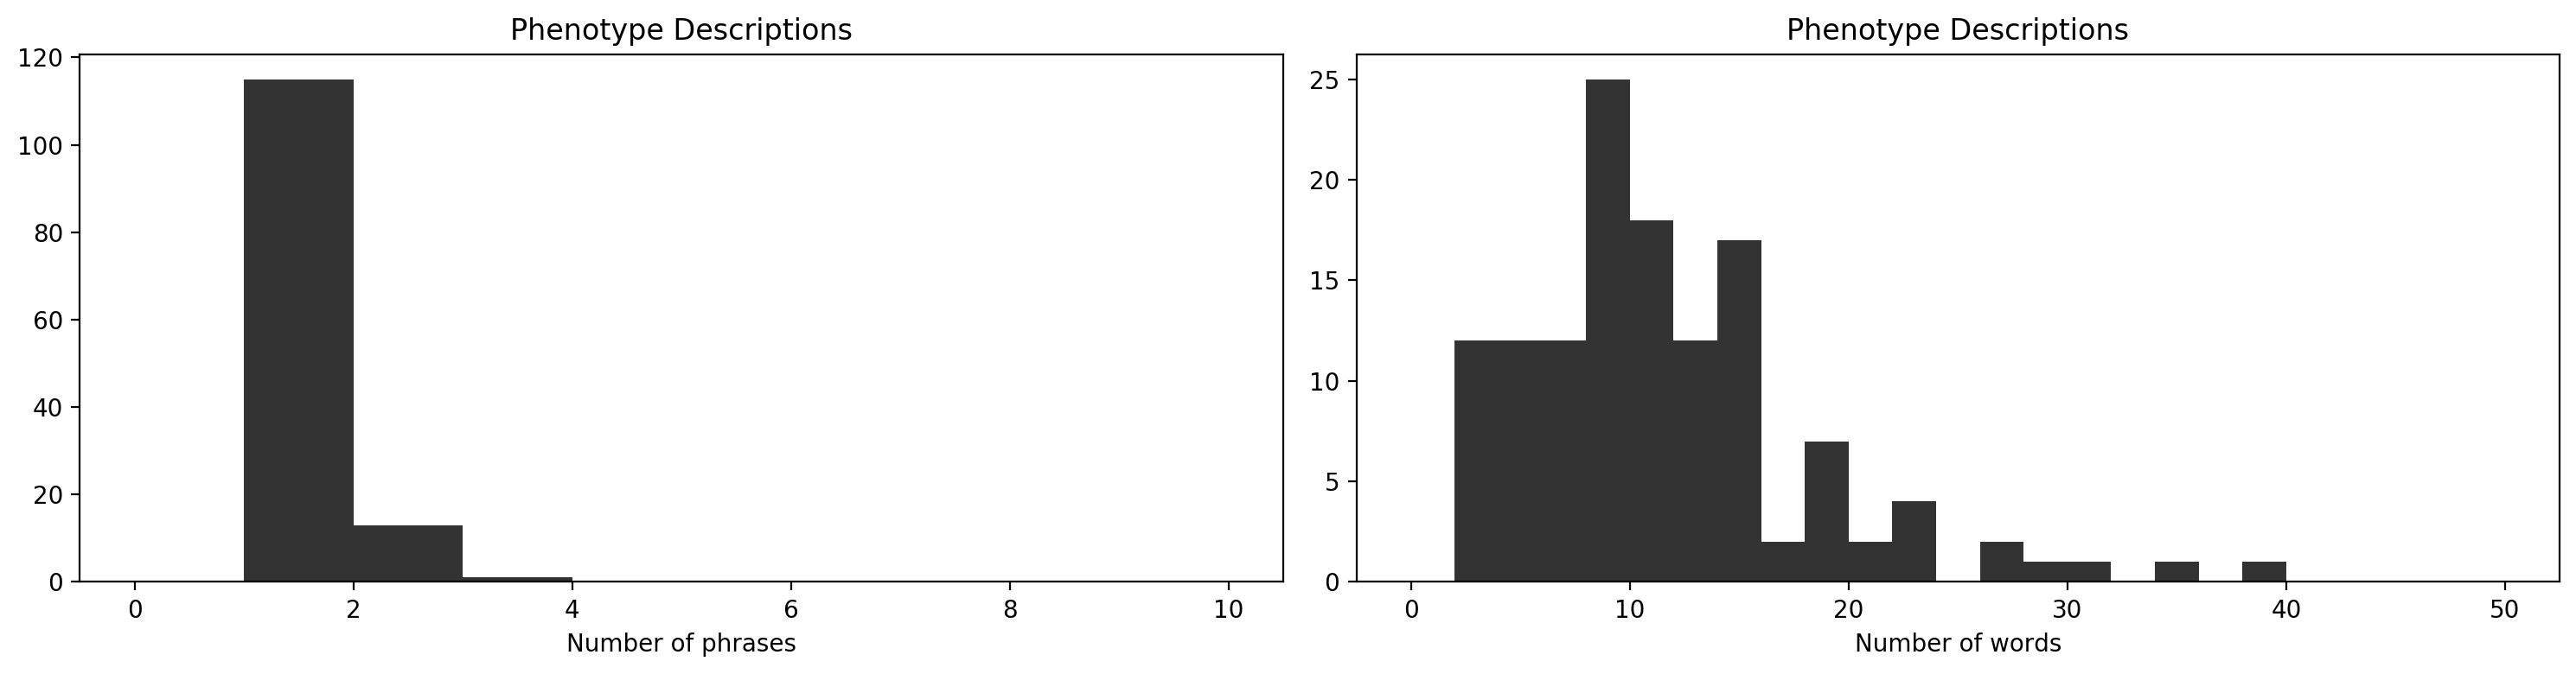

In [20]:
# Plotting distributions of number of word and phrases in each description.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Phenotype Descriptions")
ax2.set_title("Phenotype Descriptions")
ax1.set_xlabel("Number of phrases")
ax2.set_xlabel("Number of words")
x1 = [len(sent_tokenize(x)) for x in df["allele_phenotype"].values]
x2 = [len(word_tokenize(x)) for x in df["allele_phenotype"].values]
ax1.hist(x1, bins=10, range=(0,10), density=False, alpha=0.8, histtype='stepfilled', color="black", edgecolor='none')
ax2.hist(x2, bins=25, range=(0,50), density=False, alpha=0.8, histtype='stepfilled', color="black", edgecolor='none')
fig.set_size_inches(15,4)
fig.tight_layout()
fig.show()

In [21]:
# Organizing the desired information into a standard set of column headers.
df["species"] = "sly"
df["description"] = df["allele_phenotype"]
df["gene_names"] = df["locus"]
df["term_ids"] = ""
df["pmid"] = ""
df = df[["species", "gene_names", "description", "term_ids", "pmid"]]
df.head(10)

,species,gene_names,description,term_ids,pmid
0,sly,Solyc01g008710,Inactive allele of mannosidase that occurs in ...,,
1,sly,Solyc01g009070,deficient in gibberelin (GA) and their seeds r...,,
2,sly,Solyc01g056340,Similar to hp-1; enhances all pigments of gree...,,
3,sly,Solyc01g056340,Immature fruit color normal; darker green colo...,,
4,sly,Solyc01g056340,Similar to hp-2.,,
5,sly,Solyc01g079620,Fruit epidermis lacks pigmentation.,,
6,sly,Solyc01g091630,Extremely low levels (less than 2%) of cutin i...,,
7,sly,Solyc01g100490,Upper leaves smaller and chlorotic interveinal...,,
8,sly,Solyc01g100490,"This mutant is an auxotroph for nicotianmine, ...",,
9,sly,Solyc01g104340,"Resembles gf, except that center of fruit turn...",,


In [22]:
path = os.path.join(OUTPUT_DIR,"sly_phenotypes.csv")
df.to_csv(path, index=False)